# Import libraries

In [1]:
import sys
from pathlib import Path
sys.path.insert(0,'..')
import glob
#!pip install openpyxl

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import h5py
import re

from functools import partial
from multiprocessing import Pool

from lhcsmapi.Time import Time
from lhcsmapi.Timer import Timer
from scipy import signal


from src.utils.utils import log_acquisition
from src.utils.hdf_tools import acquisition_to_hdf5, load_from_hdf_with_regex, data_list_to_df
from src.visualisation.visualisation import plot_hdf
from src.modeling.sec_quench import *

pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')


In [14]:
%matplotlib inline

# Read the (clean) MP3 file

In [5]:
mp3_fpa_df = pd.read_csv("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
len(mp3_fpa_df)

3981

# Select events to download

In [6]:
mp3_fpa_df_unique = mp3_fpa_df.drop_duplicates(subset=['timestamp_fgc', 'Circuit Name'])

In [7]:
lower_limit = Time.to_unix_timestamp('2014-01-01 00:00:00+01:00')
mp3_fpa_df_period = mp3_fpa_df_unique[mp3_fpa_df_unique['timestamp_fgc'] >= lower_limit].reset_index(drop=True) 


mp3_fpa_df_period_all = mp3_fpa_df[mp3_fpa_df['timestamp_fgc'] >= lower_limit].reset_index(drop=True) 
print(len(mp3_fpa_df_period), len(mp3_fpa_df_period_all))

822 3981


# Define Paths

In [8]:
file_path  = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals')

data_path = file_path / '20220707_data'
#simulation_path_old = file_path / 'archive/20220627_simulation'
simulation_path = file_path / '20220707_simulation'
plots_path = file_path / 'plots'

In [9]:
row = {'circuit_type': 'RB',
       'Circuit Name': 'RB.A78',
       'timestamp_fgc': 1616962174400000000}

quench_number = 2
sec_quench_number = quench_number - 2

fpa_identifier = f"{row['circuit_type']}_{row['Circuit Name']}_{int(row['timestamp_fgc'])}"
data_dir = data_path / (fpa_identifier + ".hdf5")

mp3_fpa_df_subset = mp3_fpa_df[(mp3_fpa_df.timestamp_fgc == row['timestamp_fgc']) & (mp3_fpa_df['Circuit Name'] == row['Circuit Name'])]

simulation_dir = simulation_path  / (fpa_identifier + ".hdf")
simulation_dir_old = simulation_path_old  / (fpa_identifier + ".hdf")
data_dir = data_path  / (fpa_identifier + ".hdf5")

# Compare U_Diode from Dataset

In [20]:
from src.datasets.rb_fpa_full_quench import RBFPAFullQuench

dataset_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_full_dataset")
plot_dataset_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_full_dataset_plots")

context_path = Path("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
acquisition_summary_path = Path("../data/20220707_acquisition_summary.xlsx")
data_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_data")
simulation_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_simulation")
metadata_path = Path("../data/RB_metadata.csv")

In [21]:
ds = RBFPAFullQuench(dataset_path=dataset_path,
             context_path=context_path,
             metadata_path=metadata_path,
             data_path=data_path,
             simulation_path=simulation_path,
             acquisition_summary_path=acquisition_summary_path,
             plot_dataset_path=plot_dataset_path)

fpa_identifiers = ds.select_events()

dataset = ds.load_dataset(fpa_identifiers=fpa_identifiers, 
                          dataset_path=dataset_path, 
                          drop_data_vars=['el_position_feature','event_feature'])

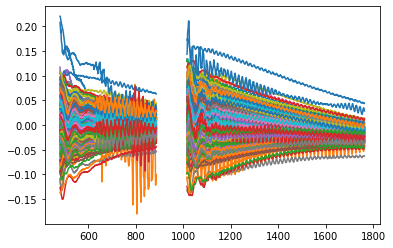

In [56]:
bool_plateau = ((data_event.time > 0.2) & (data_event.time < 0.58)) | ((data_event.time > 0.7) & (data_event.time < 1.4))
difference_plateaus[~bool_plateau.values] = np.nan
plt.plot(difference_plateaus)
plt.show()

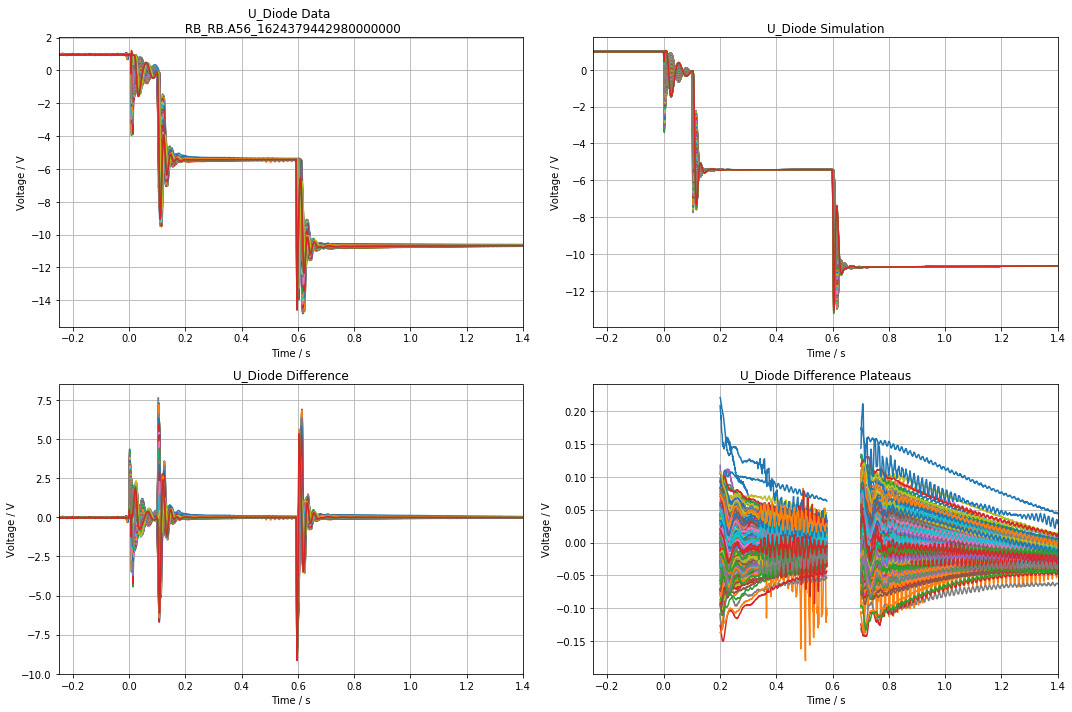

In [57]:
data_event = dataset[{'event':400}] 
fpa_identifier =  data_event.event.values
difference = data_event.data.values.T - data_event.simulation.values.T
difference_plateaus = difference.copy()
bool_plateau = ((data_event.time > 0.2) & (data_event.time < 0.58)) | ((data_event.time > 0.7) & (data_event.time < 1.4))
difference_plateaus[~bool_plateau.values] = np.nan

fig, ax = plt.subplots(2, 2, figsize = (15,10))
ax[0, 0].plot(data_event.time, data_event.data.values.T)
ax[0, 0].set_xlim((-0.25,1.4))
ax[0, 0].set_title(f'U_Diode Data \n {fpa_identifier}')
ax[0, 0].set_xlabel('Time / s')
ax[0, 0].set_ylabel('Voltage / V')
ax[0, 0].grid()

ax[0, 1].plot(data_event.time, data_event.simulation.values.T)
ax[0, 1].set_xlim((-0.25,1.4))
ax[0, 1].set_title('U_Diode Simulation')
ax[0, 1].set_xlabel('Time / s')
ax[0, 1].set_ylabel('Voltage / V')
ax[0, 1].grid()


ax[1, 0].set_title('U_Diode Difference')
ax[1, 0].plot(data_event.time, difference)
ax[1, 0].set_xlabel('Time / s')
ax[1, 0].set_ylabel('Voltage / V')
ax[1, 0].set_xlim((-0.25,1.4))
ax[1, 0].grid()

ax[1, 1].set_title('U_Diode Difference Plateaus')
ax[1, 1].plot(data_event.time, difference_plateaus)
ax[1, 1].set_xlabel('Time / s')
ax[1, 1].set_ylabel('Voltage / V')
ax[1, 1].set_xlim((-0.25,1.4))
ax[1, 1].grid()

plt.tight_layout()
plt.show()

## Analyze one event

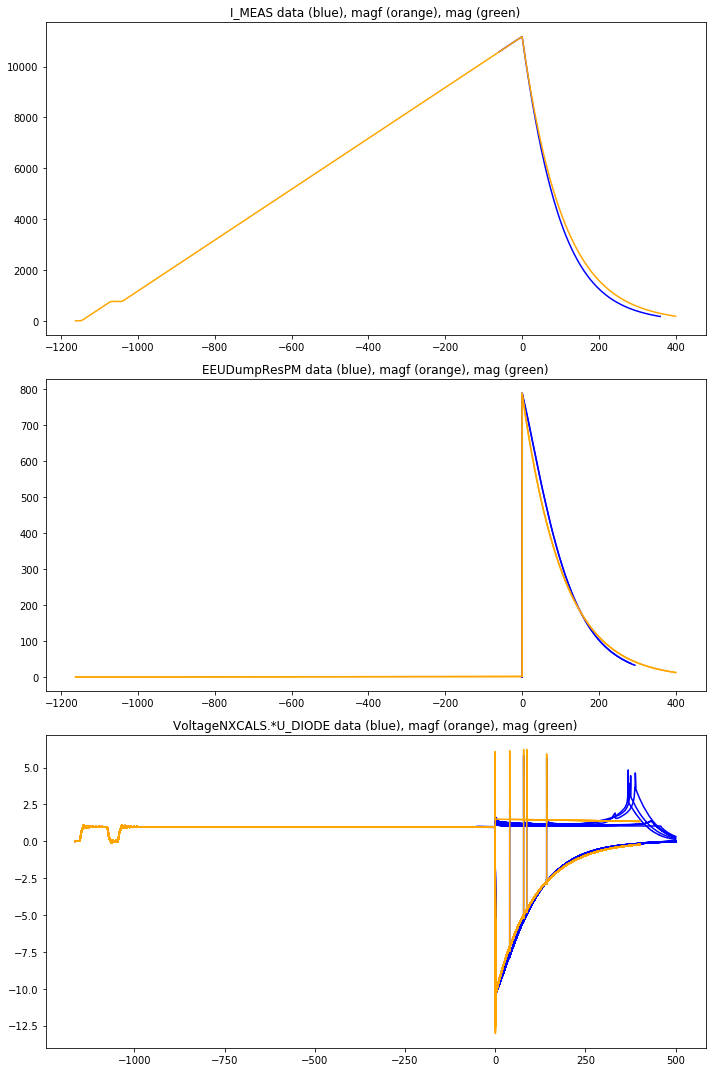

In [16]:
regex_list = ["I_MEAS",  "EEUDumpResPM", "VoltageNXCALS.*U_DIODE"]
regex_list_sim = ['r1_warm', "V\(1", "0v_magf"]
regex_list_sim_old = ['r1_warm', "V\(1", "0v_mag"]

data_sim = load_from_hdf_with_regex(file_path=simulation_dir, regex_list=regex_list_sim)
df_simulation_all = pd.concat(data_sim, axis=1) 

fig, ax = plt.subplots(3,1, figsize=(10,15))
i=0
for regex, regex_sim in zip(regex_list, regex_list_sim):
    data = load_from_hdf_with_regex(data_dir, regex_list=[regex])
    for df in data:
        df.plot(ax=ax[i], legend=False, title=f"{regex} data (blue), magf (orange), mag (green)", c="blue")
        
    #df_simulation_all_old.filter(regex=regex_sim_old).plot(ax=ax[i], legend=False, c = "green")
    
    df_simulation_all.filter(regex=regex_sim).plot(ax=ax[i], legend=False, c = "orange")
    
    plt.setp(ax[i], xlim=ax[i].get_xlim(), ylim=ax[i].get_ylim())
    i+=1
    
plt.tight_layout()

# Compare data and simulations

In [10]:
def load_data_simulation_comparison(regex_list, regex_list_sim, file_dir, simulation_dir, quenchtimes):  
    data = load_from_hdf_with_regex(file_path=file_dir, regex_list=regex_list)
    df_data = data_list_to_df(data)

    data_sim = load_from_hdf_with_regex(file_path=simulation_dir, regex_list=regex_list_sim)
    df_simulation = pd.concat(data_sim, axis=1) 

    cut_list = [get_df_time_window(df_data, timestamp) for timestamp in quenchtimes]
    cut_list_sim = [get_df_time_window(df_simulation, timestamp) for timestamp in quenchtimes]
    return cut_list, cut_list_sim
    
def plot_data_simulation_comparison(sec_quenches, sec_quenches_sim):
    fig, ax = plt.subplots(len(sec_quenches), 2, figsize=(10,10))
    i =0
    for df, df_sim in zip(sec_quenches, sec_quenches_sim):
        df.plot(legend=False, ax=ax[i,0])
        ax[i,0].set_title("data")
        ax[i,0].set_xlabel("Time \ s")
        ax[i,0].set_ylabel("Voltage \ V")

        df_sim.plot(legend=False, ax=ax[i,1])
        ax[i,1].set_title("simulations")
        ax[i,1].set_xlabel("Time \ s")
        ax[i,1].set_ylabel("Voltage \ V")

        #plt.setp(ax[i], ylim=ax[i,1].get_ylim())
        i+=1
    plt.tight_layout()

In [11]:
file_dir = file_path / '20220707_data' / (fpa_identifier + ".hdf5")
simulation_dir = simulation_path  / (fpa_identifier + ".hdf")

## I Meas

In [12]:
regex_list=["I_MEAS"]#, "EEUDumpResPM"]
regex_list_sim = ['r1_warm']#, "RB_EE"]

quenchtimes=mp3_fpa_df_subset["Delta_t(iQPS-PIC)"].values / 1e3
cut_list, cut_list_sim = load_data_simulation_comparison(regex_list, regex_list_sim, file_dir, simulation_dir, quenchtimes)
plot_data_simulation_comparison(cut_list, cut_list_sim)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## U EE

In [13]:
regex_list=["EEUDumpResPM"]
regex_list_sim = ["V\(1"]

quenchtimes=mp3_fpa_df_subset["Delta_t(iQPS-PIC)"].values / 1e3
cut_list, cut_list_sim = load_data_simulation_comparison(regex_list, regex_list_sim, file_dir, simulation_dir, quenchtimes)
plot_data_simulation_comparison(cut_list, cut_list_sim)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## U_Diode: Quenched magnets are included

In [14]:
data = load_from_hdf_with_regex(file_path / '20220707_data' / (fpa_identifier + ".hdf5"), regex_list=["VoltageNXCALS.*U_DIODE"])
df_data = data_list_to_df(data)

sec_quenches = get_sec_quench_frame_exclude_quench(df_data=df_data, 
                                 all_quenched_magnets=mp3_fpa_df_subset.Position.values, 
                                 quench_times=mp3_fpa_df_subset["Delta_t(iQPS-PIC)"].values /1e3, 
                                 time_frame=2)

In [15]:
sorted_columns = [f"V(0v_mag{i})"for i in range(1, len(df_simulation_all.filter(regex="0v_mag").columns)+1)]
df_simulation = df_simulation_all[sorted_columns]

df_metadata = MappingMetadata.read_layout_details("RB")
df_metadata = df_metadata[df_metadata.Circuit ==row['Circuit Name']].sort_values("#Electric_circuit")

magnet_names = df_metadata.Magnet.apply(lambda x: x + ":U_DIODE_RB" ).values
df_simulation.columns = magnet_names

sec_quenches_sim = get_sec_quench_frame_exclude_quench(df_data=df_simulation, 
                                 all_quenched_magnets=mp3_fpa_df_subset.Position.values, 
                                 quench_times=mp3_fpa_df_subset["Delta_t(iQPS-PIC)"].values /1e3, 
                                 time_frame=2)

In [16]:
plot_data_simulation_comparison(sec_quenches, sec_quenches_sim)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Analyze wiggle of one event

In [17]:
data = load_from_hdf_with_regex(file_path / '20220707_data' / (fpa_identifier + ".hdf5"), regex_list=["VoltageNXCALS.*U_DIODE"])
df_data_nxcals = data_list_to_df(data)

sec_quenches = get_sec_quench_frame_exclude_quench(df_data=df_data_nxcals, 
                                 all_quenched_magnets=mp3_fpa_df_subset.Position.values, 
                                 quench_times=mp3_fpa_df_subset["Delta_t(iQPS-PIC)"].values /1e3, 
                                 time_frame=2)

In [18]:
df_quench_frame = sec_quenches[sec_quench_number]

df_quench_frame.plot(legend=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [21]:
df_std = get_std_of_diff(df=df_quench_frame)
df_std_meta = sort_by_metadata(
    df=df_std, 
    quenched_magnet=mp3_fpa_df_subset.Position.values[sec_quench_number+1],
    circuit=row["Circuit Name"],
    by="#Electric_EE")

dstd_score = get_dstd_score(df_std_meta, window_len=15)
dstd_score_exp = get_dstd_score(df_std_meta, window_len=15, window_function=signal.windows.exponential, tau=2)
dstd_score_tuk = get_dstd_score(df_std_meta, window_len=15, window_function=signal.windows.tukey)

idx_0 = df_quench_frame.index[0]
idx_min = df_quench_frame.min(axis=1).idxmin()
idx_max = df_quench_frame.max(axis=1).idxmax()
min_time = idx_min - idx_0
max_time = idx_max - idx_0
min_amplitude = df_quench_frame.loc[idx_min].mean() -df_quench_frame.loc[idx_min].min() 
max_amplitude = df_quench_frame.loc[idx_max].max() - df_quench_frame.loc[idx_max].mean()

wiggle_area = calc_wiggle_area(df_std_meta)

df_std_meta["dstd_medfilt"] = df_std_meta.dstd.rolling(3).median()
df_std_meta.plot(x ="distance_to_quench", y=["dstd"])
plt.title(f"max: {max_amplitude:.3f}@{max_time:.2f} min:{min_amplitude:.3f}@{min_time:.2f} \n wiggle_area: {wiggle_area} \n box: {dstd_score:.2f} exp: {dstd_score_exp:.2f} exp: {dstd_score_tuk:.2f}")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'max: 0.330@0.60 min:0.151@0.50 \n wiggle_area: 21 \n box: 2.04 exp: 2.43 exp: 2.25')